In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)

#  por si no lo tenees pip install wordcloud pillow
from wordcloud import WordCloud

# Reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# RUTAS 
TRAIN_PATH = "data/train.csv"
TEST_PATH  = "data/test.csv"

1) Cargar datos y revisar columnas (EDA básico)

In [8]:
# 1) CARGA
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# 1.1) Dimensiones y columnas
print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("\nTrain columns:", train.columns.tolist())

# 1.2) Vistazo rápido
display(train.head(10))
display(test.head(10))

# 1.3) Datos faltantes por columna
display(train.isna().mean().sort_values(ascending=False).to_frame("missing_ratio").style.format("{:.2%}"))


Train shape: (7613, 5)
Test shape : (3263, 4)

Train columns: ['id', 'keyword', 'location', 'text', 'target']


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


,missing_ratio
location,33.27%
keyword,0.80%
id,0.00%
text,0.00%
target,0.00%


El dataset trae id, keyword, location, text, target (target = 1 desastre, 0 no) .

2) Limpieza / preprocesamiento del texto (tweets)

Del enunciado: minúsculas, quitar #, @, URL, emojis, puntuación; quitar stopwords; y decidir si quitar números (ojo con “911”) .

In [ ]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
STOP_EN = set(stopwords.words("english"))

# patrones regex 
EMOJI_PATTERN   = re.compile("["           # rango de emojis comunes             
    "\U0001F600-\U0001F64F"
    "\U0001F300-\U0001F5FF"
    "\U0001F680-\U0001F6FF"
    "\U0001F1E0-\U0001F1FF"
"]+", flags=re.UNICODE)
URL_PATTERN     = re.compile(r"http\S+|www\.\S+")
MENTION_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#(\w+)")   # conserva la palabra, quita '#'
HTML_TAGS       = re.compile(r"<.*?>")

# tokens super comunes de Twitter; sklearn quitará más stopwords con stop_words="english"
TW_STOPS = {"rt", "amp"}

def clean_tweet(text: str, remove_numbers=False, preserve_911=True) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = URL_PATTERN.sub(" ", t)
    t = HTML_TAGS.sub(" ", t)
    t = MENTION_PATTERN.sub(" ", t)
    t = HASHTAG_PATTERN.sub(r"\1", t)     
    t = re.sub(r"[^a-z0-9\s]", " ", t)    
    t = EMOJI_PATTERN.sub(" ", t)

    if remove_numbers:
        if preserve_911:
            t = re.sub(r"\b(?!911\b)\d+\b", " ", t) # quita números excepto 911
        else:
            t = re.sub(r"\b\d+\b", " ", t)

    t = re.sub(r"\s+", " ", t).strip()

    tokens = t.split()

    # quitar stopwords de twitter y NLTK
    tokens = [w for w in tokens if w not in TW_STOPS and w not in STOP_EN and len(w) > 1]

    return " ".join(tokens)

# aplicar
train["clean_text"] = train["text"].apply(lambda s: clean_tweet(s, remove_numbers=False))
test["clean_text"]  = test["text"].apply(lambda s: clean_tweet(s, remove_numbers=False))

display(train[["text","clean_text","target"]].head(10))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diego\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text,target
0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us,1
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,1
2,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,1
3,"13,000 people receive #wildfires evacuation or...",13 000 people receive wildfires evacuation ord...,1
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,1
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy 20 closed dire...,1
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain causes flash floodin...,1
7,I'm on top of the hill and I can see a fire in...,top hill see fire woods,1
8,There's an emergency evacuation happening now ...,emergency evacuation happening building across...,1
9,I'm afraid that the tornado is coming to our a...,afraid tornado coming area,1


3) EDA: distribución de clases, longitudes y nubes de palabras

,count
target,
0,4342
1,3271


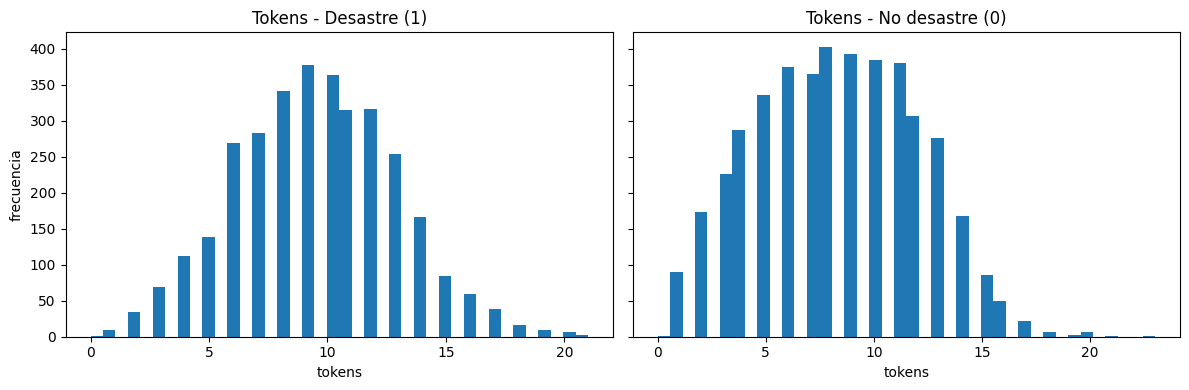

In [12]:
# 3) DISTRIBUCIÓN DE CLASES
display(train["target"].value_counts().to_frame("count"))

# 3.1) Longitud en tokens del texto limpio
train["tok_len"] = train["clean_text"].str.split().apply(len)

fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
train.loc[train["target"]==1, "tok_len"].plot(kind="hist", bins=40, ax=ax[0], title="Tokens - Desastre (1)")
train.loc[train["target"]==0, "tok_len"].plot(kind="hist", bins=40, ax=ax[1], title="Tokens - No desastre (0)")
for a in ax: a.set_xlabel("tokens"); a.set_ylabel("frecuencia")
plt.tight_layout()
plt.show()


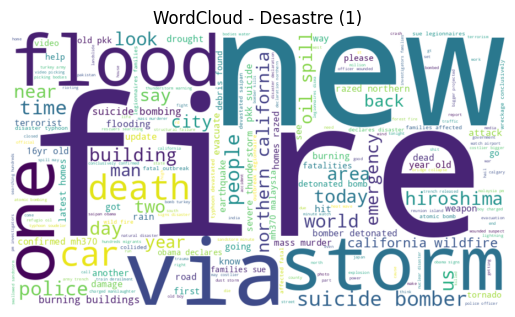

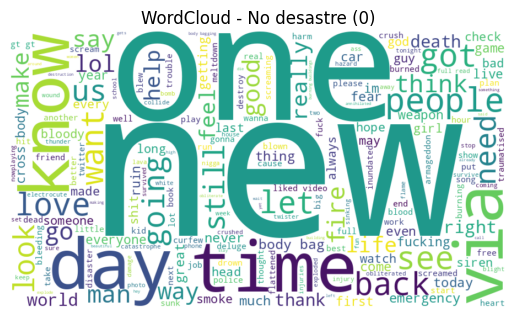

In [13]:
# 3.2) Nube de palabras por clase 
pos_text = " ".join(train.loc[train["target"]==1, "clean_text"])
neg_text = " ".join(train.loc[train["target"]==0, "clean_text"])

wc_pos = WordCloud(width=900, height=500, background_color="white").generate(pos_text)
plt.imshow(wc_pos, interpolation="bilinear"); plt.axis("off"); plt.title("WordCloud - Desastre (1)"); plt.show()

wc_neg = WordCloud(width=900, height=500, background_color="white").generate(neg_text)
plt.imshow(wc_neg, interpolation="bilinear"); plt.axis("off"); plt.title("WordCloud - No desastre (0)"); plt.show()


4) Frecuencias de palabras y n‑gramas (unigramas/bigramas)

El lab pide contar frecuencias por categoría y discutir si vale explorar bigramas/trigramas .

In [14]:
# 4) TOP UNIGRAMAS POR CLASE
def top_terms(df, target_value, n=25):
    vec = CountVectorizer(ngram_range=(1,1), min_df=2, stop_words="english")
    X = vec.fit_transform(df.loc[df["target"]==target_value, "clean_text"])
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"term": terms[order], "freq": freqs[order]})

top_uni_1 = top_terms(train, 1, n=30)
top_uni_0 = top_terms(train, 0, n=30)

display(top_uni_1.head(20))
display(top_uni_0.head(20))


,term,freq
0,news,137
1,disaster,121
2,california,115
3,suicide,112
4,police,109
5,people,105
6,killed,95
7,like,94
8,hiroshima,92
9,storm,89


,term,freq
0,like,254
1,new,171
2,body,116
3,video,96
4,people,94
5,love,91
6,day,86
7,know,86
8,time,84
9,got,84


###  4.1) TOP BIGRAMAS POR CLASE

In [15]:
def top_bigrams(df, target_value, n=25):
    vec = CountVectorizer(ngram_range=(2,2), min_df=3, stop_words="english")
    X = vec.fit_transform(df.loc[df["target"]==target_value, "clean_text"])
    if X.shape[1] == 0:
        return pd.DataFrame(columns=["bigram","freq"])
    freqs = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())
    order = np.argsort(freqs)[::-1][:n]
    return pd.DataFrame({"bigram": terms[order], "freq": freqs[order]})

top_bi_1 = top_bigrams(train, 1, n=30)
top_bi_0 = top_bigrams(train, 0, n=30)

display(top_bi_1.head(20))
display(top_bi_0.head(20))

,bigram,freq
0,suicide bomber,59
1,northern california,41
2,oil spill,38
3,burning buildings,37
4,suicide bombing,35
5,california wildfire,34
6,bomber detonated,30
7,70 years,30
8,homes razed,29
9,confirmed mh370,29


,bigram,freq
0,cross body,39
1,liked video,34
2,gt gt,30
3,body bag,27
4,body bagging,24
5,burning buildings,23
6,body bags,22
7,reddit quarantine,21
8,quarantine offensive,21
9,looks like,21


### 4.2) Esto ya se hizo pero para un analisis mejor en BARRAS (Top 20)  (unigramas)

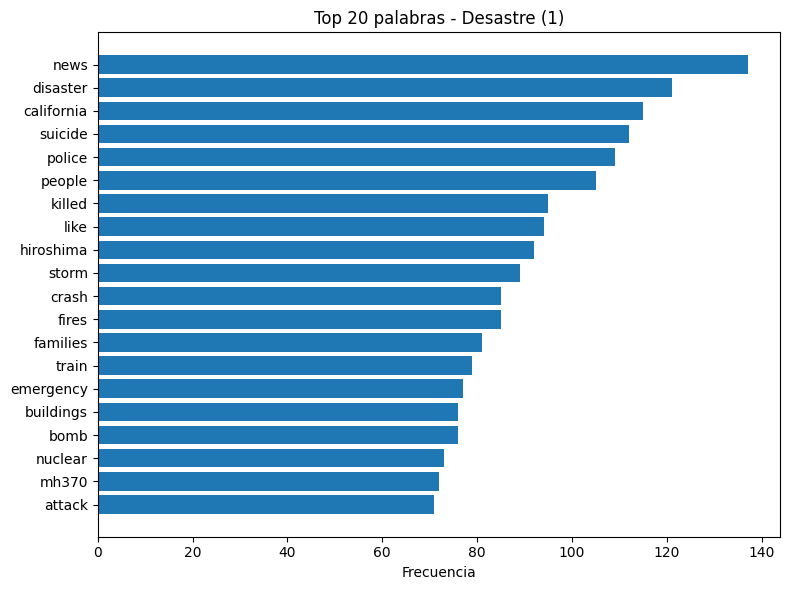

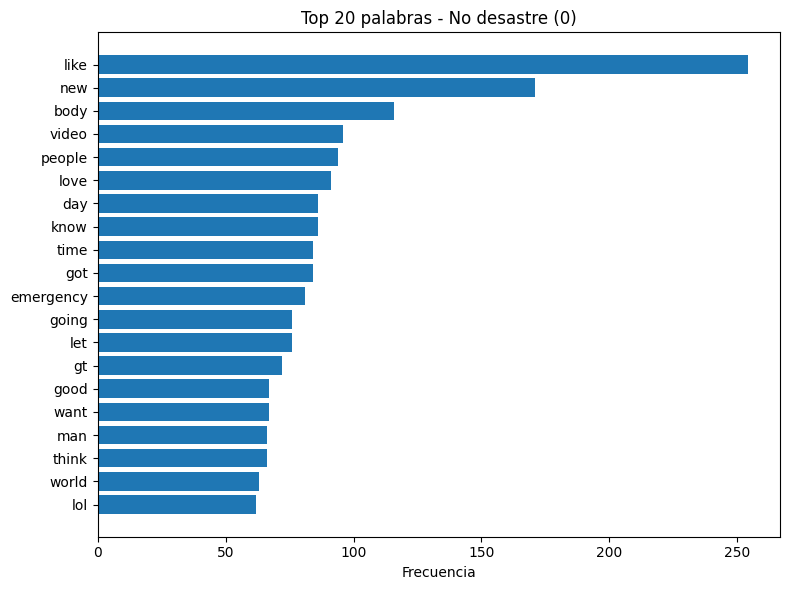

In [16]:
def barh_terms(df, term_col="term", freq_col="freq", title=""):
    df20 = df.head(20).iloc[::-1]
    plt.figure(figsize=(8,6))
    plt.barh(df20[term_col], df20[freq_col])
    plt.title(title); plt.xlabel("Frecuencia"); plt.tight_layout(); plt.show()

barh_terms(top_uni_1, "term","freq", "Top 20 palabras - Desastre (1)")
barh_terms(top_uni_0, "term","freq", "Top 20 palabras - No desastre (0)")